In [1]:
#https://seisbench.readthedocs.io/en/stable/pages/models.html
# !pip install seisbench

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seisbench.models as sbm
from obspy import read_events
from obspy import read_inventory
from seisbench.util.annotations import ClassifyOutput
import pickle
import progressbar
###
import MyFuncs as mf
from MyFuncs.structure import Result
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import Catalog as inspcat
from obspy import Catalog

In [2]:
residuals_threshold = 5

In [3]:
# import sys
# gdrive_path = '/content/drive/MyDrive'
# working_path = f'{gdrive_path}/Colab Notebooks/JSEE_SeisBench_1402-06-30'
# sys.path.append(working_path)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# data_path = f'{gdrive_path}/Colab Notebooks/PhD-Thesis_ImanKahbasi'
working_path =  '.'
data_path = f'{working_path}/IIEES_2006-2023'
Details_lst_filenames = glob.glob(f'{data_path}/Details/*')
catalog = read_events(f'{data_path}/BIN_2004_2024-Cleaned.out')
inventory = read_inventory(f'{data_path}/BI_2022-09-14.dataless')
eventid2catalog = mf.funcs.eventid2catalog(Details_lst_filenames, catalog)

In [6]:
selected_catalog = Catalog([v for k, v in eventid2catalog.items()])


In [7]:
insp = inspcat.inspector(catalog=selected_catalog)

In [13]:
with open(f'{data_path}/BIN_2004_2024-Cleaned.csv', 'w') as output:
    output.write('otime,latitude,longitude,magnitude\n')
    for ev in selected_catalog:
        origin = ev.preferred_origin()
        magnitude = ev.preferred_magnitude().mag
        output.write(f'{origin.time},{origin.latitude},{origin.longitude},{magnitude}\n')

In [10]:
lst_station_name = ['KHRK', 'JSSH', 'ABGH', 'KAGH', 'GTMR', 'SRSL', 'ILBA',
                    'GIDE', 'YZKH', 'BSRN', 'AHRM', 'CHBR', 'TABS', 'SHRT',
                    'SHRO', 'KHMZ', 'RMKL', 'ZNJK', 'BJRD', 'MRVT', 'GHVR',
                    'SHGR', 'KRBR', 'CHTH', 'MAKU', 'SNGE', 'DAMV', 'BNDS',
                    'GRMI', 'GHIR', 'ZHSF', 'THKV', 'NASN', 'ASAO', 'SHRD']

In [11]:
lst_station_name = '|'.join(lst_station_name)
### Select the stations that exist on the list of stations
insp.df_phases = insp.df_phases[insp.df_phases['station'].str.contains(lst_station_name, case=False)]

In [12]:
p_count_total = sum(insp.df_phases['phase'].str.upper().str.startswith('P'))
s_count_total = sum(insp.df_phases['phase'].str.upper().str.startswith('S'))

In [13]:
s_count_total

781

In [14]:
p_count_total

8206

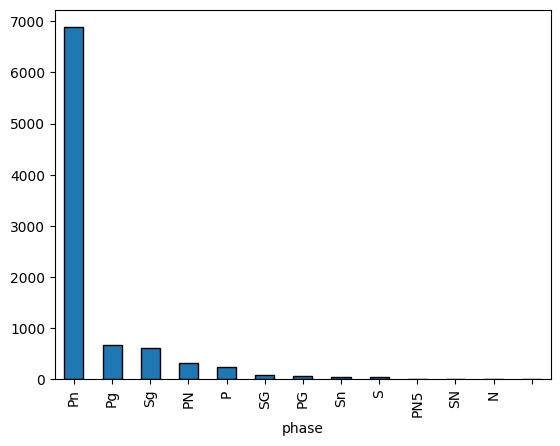

In [15]:
insp.plot_bar_phasetype()

# Load Deep Learning phases

In [16]:
run_name = '20240130T125708'
autopick_root = f'{working_path}/DL-picks-results_{run_name}'
lst_results = []
for rootw, dirsw, filesw in os.walk(autopick_root):
    if 'DL' in rootw:
        for filew in filesw:
            if filew.endswith('.pickle'):
                lst_results.append(f'{rootw}/{filew}')

In [17]:
# import importlib
# importlib.reload(mf.funcs)

In [18]:
metadata = pd.read_csv(f'metadata-of-run_{run_name}.csv')
metadata['autopick'] = None
metadata['manualpick'] = None
metadata['manualarrival'] = None

In [19]:
counts = metadata['eventid'].unique()
# counts.plot(kind='bar', title='eventid')
counts.size

843

In [20]:
def load_autopicks(fname):
    with open(fname, 'rb') as fileObj:
        picks = pickle.load(fileObj)
    return picks

In [21]:
for indx, row in metadata.iterrows():
    path = glob.glob(f'./{autopick_root}/eID-{row.eventid}_*_{row.picker_name}_{row.execution_time}.pickle')
    picks = load_autopicks(fname=path[0])
    # print(picks)
    metadata.at[indx, 'autopick'] = picks

In [22]:
df = metadata.explode(['autopick'])
df = df.reset_index()
df = df.drop(labels=['index'], axis=1)


In [23]:
def select_ArrivalOfPick(pick, ev):
    origin = ev.preferred_origin()
    find_arrival = False
    for arrival in origin.arrivals:
        if pick.resource_id == arrival.pick_id:
            find_arrival = True
            break
    if not find_arrival:
        find_arrival = None
    return arrival

In [24]:
df.shape

(670508, 13)

In [25]:
print(sum(df['autopick'].isna()))
df = df[~df['autopick'].isna()]

94


In [26]:
for indx, row in df.iterrows():
    ev = eventid2catalog[str(row.eventid)]
    # print(indx, row.autopick.trace_id)
    net, sta, loc = row.autopick.trace_id.split('.')
    for pick in ev.picks:
        # print(pick)
        if (pick.waveform_id.station_code == sta) and (row.autopick.phase in pick.phase_hint.upper()):
            arrival = select_ArrivalOfPick(pick, ev)
            ###
            # print(indx, pick, arrival)
            df.at[indx, 'manualpick'] = pick
            df.at[indx, 'manualarrival'] = arrival

In [27]:
df['station'] = df['autopick'].apply(lambda x: x.trace_id.split('.')[1])
df['phasetype'] = df['autopick'].apply(lambda x: x.phase)

In [28]:
df['freqmin'][df['freqmin'].isna()] = 'No'
df['freqmax'][df['freqmax'].isna()] = 'No'
df['DPDN'][~df['DPDN']] = 'No'

In [29]:
'''
df_ar: dataframe auto and reference
DataFrame of the phases that exist in the reference catalog
and picked with autopicker.
'''
df_ar = df[df['manualpick'].notna()]

### DataFrame of the new detection that doesn't exist in reference catalog.
df_new = df[df['manualpick'].isna()]
df_new.shape

(558209, 15)

In [30]:
'''
extract the features of reference catalog.
'''
df_ar['dist_cat'] = df_ar['manualarrival'].apply(lambda x: x.distance) * 111
df_ar['time_cat'] = df_ar['manualpick'].apply(lambda x: x.time)
df_ar['res_cat'] = df_ar['manualarrival'].apply(lambda x: x.time_residual)

extract the features of automatical picks.

In [31]:
df_ar['weight'] = df_ar['autopick'].apply(lambda x: x.peak_value)
df_ar['time_autopick'] = df_ar['autopick'].apply(lambda x: x.peak_time)

In [32]:
df_ar['time_diff'] = df_ar['time_autopick'] - df_ar['time_cat']
df_ar.shape

(112205, 21)

In [33]:
# lst_station_name = ['KHRK', 'JSSH', 'ABGH', 'KAGH', 'GTMR', 'SRSL', 'ILBA',
#                     'GIDE', 'YZKH', 'BSRN', 'AHRM', 'CHBR', 'TABS', 'SHRT',
#                     'SHRO', 'KHMZ', 'RMKL', 'ZNJK', 'BJRD', 'MRVT', 'GHVR',
#                     'SHGR', 'KRBR', 'CHTH', 'MAKU', 'SNGE', 'DAMV', 'BNDS',
#                     'GRMI', 'GHIR', 'ZHSF', 'THKV', 'NASN', 'ASAO', 'SHRD']
print(f'lst_station_name, ({len(lst_station_name)})')
lst_station_name = '|'.join(lst_station_name)
### Select the stations that exist on the list of stations
df_compare2 = df_ar[df_ar['station'].str.contains(lst_station_name, case=False)]
df_compare2.shape

lst_station_name, (174)


(112205, 21)

In [34]:
df_ar['station'][~df_ar['station'].str.contains(lst_station_name, case=False)].unique()

array([], dtype=object)

In [35]:
df_min_res = df_ar[abs(df_ar['time_diff']) <= residuals_threshold]
df_min_res = df_min_res.reset_index()
df_min_res.shape

(30677, 22)

In [36]:
def pick_counter(df, cols):
    g = df[cols]
    g['count'] = 1
    g = g.groupby(cols)
    g = g.count().reset_index()
    return g

In [37]:
cols = ['picker_name', 'phasetype','DPDN', 'freqmin', 'freqmax']
count_picks_all = pick_counter(df_min_res,
                               cols = cols)
count_picks_all['category'] = 'All'
count_picks_all

,picker_name,phasetype,DPDN,freqmin,freqmax,count,category
0,BasicPhaseAE,P,No,No,No,774,All
1,BasicPhaseAE,S,No,No,No,54,All
2,EQTransformer,P,No,No,No,4706,All
3,EQTransformer,S,No,No,No,456,All
4,GPD,P,No,No,No,10269,All
5,GPD,S,No,No,No,1392,All
6,PhaseNet,P,No,No,No,6746,All
7,PhaseNet,S,No,No,No,333,All
8,STALTA,P,No,No,No,5947,All


In [38]:
'''
df_uniqe: if in each window (+-residuals_threshold around reference pick)
there is only one auto pick exist.
'''
cols = ['eventid', 'station', 'picker_name', 'phasetype',
        'DPDN', 'freqmin', 'freqmax']
df_uniqe = df_min_res.groupby(cols)
df_uniqe = df_uniqe.filter(lambda x: len(x) == 1)
df_uniqe = df_uniqe.reset_index()
df_uniqe.shape

(21632, 23)

In [39]:
df_min_res.keys()

Index(['index', 'eventid', 'wavename', 'execution_time', 'RunTimeEQ',
       'freqmin', 'freqmax', 'DPDN', 'picker_name', 'training_data',
       'detection_threshold', 'autopick', 'manualpick', 'manualarrival',
       'station', 'phasetype', 'dist_cat', 'time_cat', 'res_cat', 'weight',
       'time_autopick', 'time_diff'],
      dtype='object')

In [40]:
cols = ['eventid', 'station', 'picker_name', 'phasetype',
        'DPDN', 'freqmin', 'freqmax']
df_max_weight = df_min_res.sort_values(['weight']).groupby(cols).first()
df_max_weight.shape

(25449, 15)

In [41]:
cols = ['picker_name', 'phasetype','DPDN', 'freqmin', 'freqmax']
count_picks_uniqe = pick_counter(df_uniqe,
                               cols = cols)
count_picks_uniqe['category'] = 'Uniqe'
count_picks_uniqe

,picker_name,phasetype,DPDN,freqmin,freqmax,count,category
0,BasicPhaseAE,P,No,No,No,747,Uniqe
1,BasicPhaseAE,S,No,No,No,50,Uniqe
2,EQTransformer,P,No,No,No,2782,Uniqe
3,EQTransformer,S,No,No,No,452,Uniqe
4,GPD,P,No,No,No,4688,Uniqe
5,GPD,S,No,No,No,319,Uniqe
6,PhaseNet,P,No,No,No,6338,Uniqe
7,PhaseNet,S,No,No,No,329,Uniqe
8,STALTA,P,No,No,No,5927,Uniqe


In [42]:
'''
df_atleast_one: window that at least has one pick in there.
'''

cols = ['eventid', 'station',
        'picker_name', 'training_data', 
        'phasetype',
        'DPDN', 'freqmin', 'freqmax']

df_atleast_one = df_min_res.drop_duplicates(subset=cols)
df_atleast_one.shape


(25449, 22)

In [43]:
cols = ['picker_name', 'phasetype','DPDN', 'freqmin', 'freqmax']
count_picks_atleast_one = pick_counter(df_atleast_one,
                                       cols = cols)
count_picks_atleast_one['category'] = 'At least'

count_picks_atleast_one

,picker_name,phasetype,DPDN,freqmin,freqmax,count,category
0,BasicPhaseAE,P,No,No,No,760,At least
1,BasicPhaseAE,S,No,No,No,52,At least
2,EQTransformer,P,No,No,No,3644,At least
3,EQTransformer,S,No,No,No,454,At least
4,GPD,P,No,No,No,7020,At least
5,GPD,S,No,No,No,709,At least
6,PhaseNet,P,No,No,No,6542,At least
7,PhaseNet,S,No,No,No,331,At least
8,STALTA,P,No,No,No,5937,At least


In [44]:
df_counts = pd.concat([count_picks_atleast_one,
                        count_picks_uniqe,
                        count_picks_all])
df_counts = df_counts.reset_index()

df_counts['id'] = df_counts[
    ['DPDN', 'freqmin', 'freqmax']].apply(
        lambda x: x.str.cat(sep='-'), axis=1)
df_counts = df_counts[['phasetype', 'category', 'count', 'picker_name']]
# df_counts = df_counts.groupby('category')
df_counts = df_counts.pivot_table(columns='picker_name',
                                  values='count',
                                  index=['phasetype', 'category'])#, values='count')
# df_counts = df_counts.set_index('picker_name')
df_counts = df_counts.reset_index()

In [45]:
# df_counts['test1'] = np.random.randint(low=1000, size=6)
# df_counts['test2'] = np.random.randint(low=1000, size=6)
# df_counts['test3'] = np.random.randint(low=1000, size=6)

# df_counts

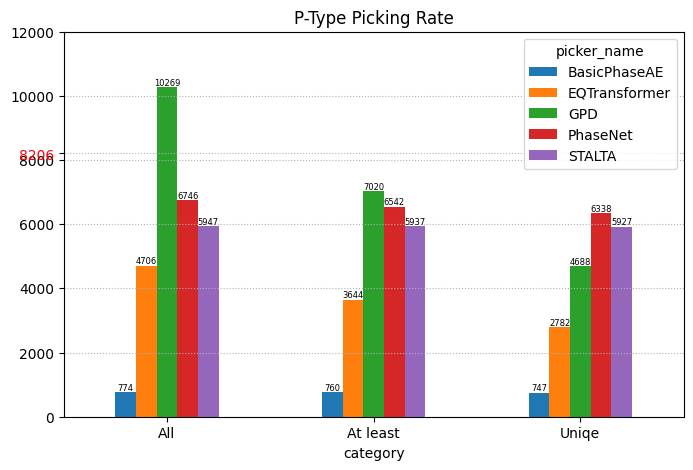

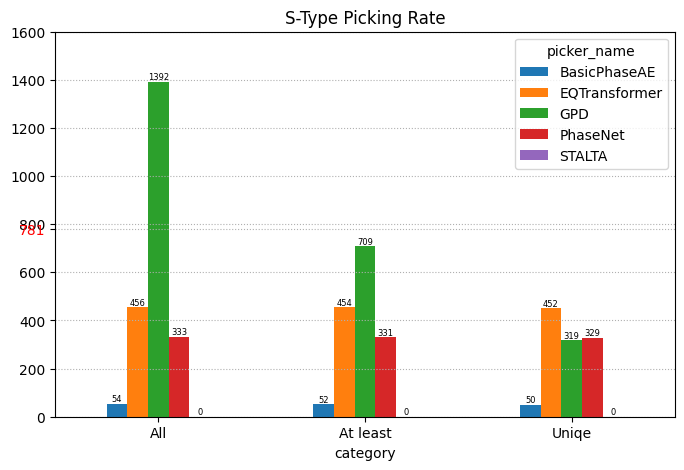

In [46]:
df_counts['Criteria'] = df_counts['category']
for phasetype in ['P', 'S']:
    fig, ax = plt.subplots(figsize=(8, 5))
    # all: 5759, P-type: 5594 S-type: 165
    if phasetype == 'P':
        target = p_count_total
    elif phasetype =='S':
        target = s_count_total
    else:
        target = 5759
    # ax.hlines(5594 , -0.2, 2.2, linestyles='-.', linewidth=4, label='Catalog')
    df_tmp = df_counts[df_counts['phasetype']==phasetype]
    df_tmp.plot(x='Criteria',
                kind='bar',
                stacked=False,
                title=f'{phasetype}-Type Picking Rate',
                fig=fig, ax=ax,
                grid=False,
                rot=0,
                linewidth=10)
    for container in ax.containers:
        ax.bar_label(container, fontsize=6)
    plt.yticks(list(plt.yticks()[0]) + [target])

    labels = plt.gca().get_yticklabels()
    label_to_change = labels[-1]
    label_to_change.set_color('red')
    plt.grid(axis='y', linestyle=':')
    plt.show()


In [54]:
count_picks_atleast_one

,picker_name,phasetype,DPDN,freqmin,freqmax,count,category
0,BasicPhaseAE,P,No,No,No,760,At least
1,BasicPhaseAE,S,No,No,No,52,At least
2,EQTransformer,P,No,No,No,3644,At least
3,EQTransformer,S,No,No,No,454,At least
4,GPD,P,No,No,No,7020,At least
5,GPD,S,No,No,No,709,At least
6,PhaseNet,P,No,No,No,6542,At least
7,PhaseNet,S,No,No,No,331,At least
8,STALTA,P,No,No,No,5937,At least


In [66]:
# test = []
# size = 9
# for ii in range(10):
#     test1 = count_picks_atleast_one.copy()
#     test1['freqmin'] = 1; test1['freqmax'] = 10; test1['DPDN'] = 'Yes'
#     test1['count'] = np.random.randint(low=1000, size=size)

#     test2 = count_picks_atleast_one.copy()
#     test2['freqmin'] = 2; test2['freqmax'] = 5
#     test2['count'] = np.random.randint(low=1000, size=size)

#     test3 = count_picks_atleast_one.copy()
#     test3['freqmin'] = 1; test3['freqmax'] = 10
#     test3['count'] = np.random.randint(low=1000, size=size)

#     test4 = count_picks_atleast_one.copy()
#     test4['count'] = np.random.randint(low=1000, size=size)

#     picker1 = pd.concat([test1, test2, test3, test4])
#     picker1['picker_name'][picker1['picker_name']=='PhaseNet'] = f'picker{ii}'
#     test.append(picker1)
# test = pd.concat(test)

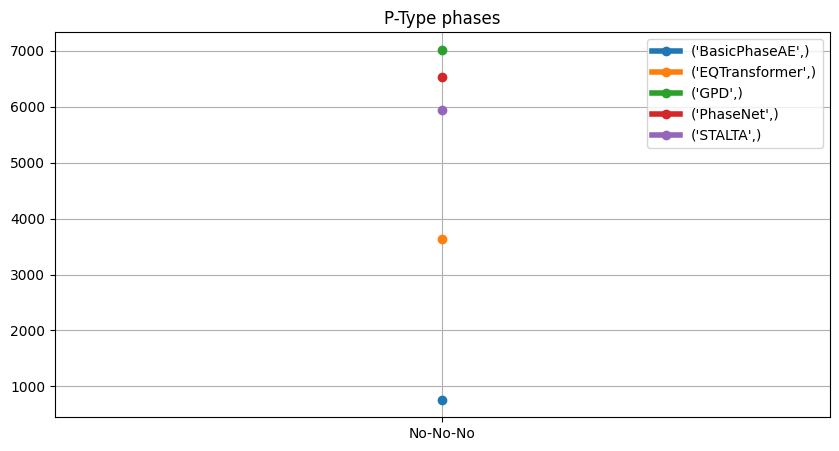

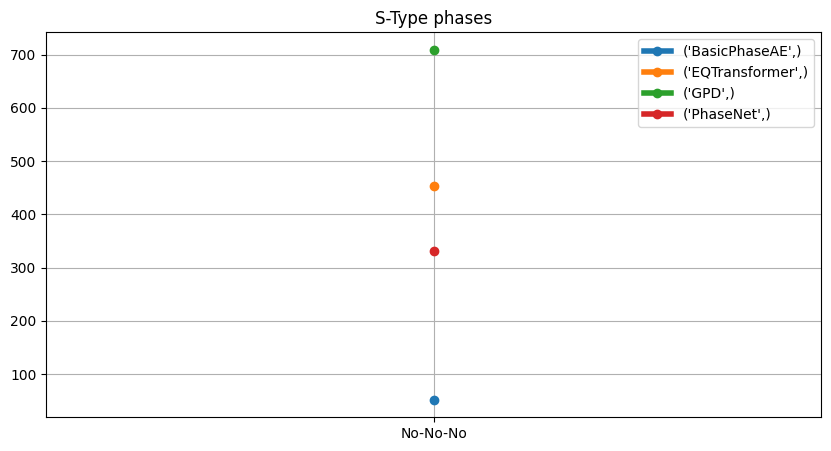

In [69]:
count = count_picks_atleast_one.copy()

count['id'] = count[
    ['DPDN', 'freqmin', 'freqmax']].astype(str).apply(
        lambda x: x.str.cat(sep='-'), axis=1)
count = count.reset_index()
for phasetype in ['P', 'S']:
    count_plot = count[count['phasetype']==phasetype]
    count_plot = count_plot[['id', 'count', 'picker_name']]
    plt.figure(figsize=(10, 5))
    for gname, gdata in count_plot.sort_values(['id']).groupby(['picker_name']):
        # print(gname, gdata)
        plt.plot(gdata['id'].values, gdata['count'].values, 'o-', label=gname, lw=4)
    plt.legend()
    plt.grid()
    plt.title(f'{phasetype}-Type phases')
    plt.show()

# Time Accuracy

In [107]:
import importlib
importlib.reload(mf.plot)

<module 'MyFuncs.plot' from '/home/ekarkooti/Documents/JSEE/SeisBench-JSEE_1402-08-16/MyFuncs/plot.py'>

In [108]:
### df_ta: dataframe for time accuracy
df_ta = df_uniqe
plot_dir = f'{working_path}/Analised'
print(plot_dir)
os.makedirs(plot_dir, exist_ok=True)

./Analised


vmax=92.0
./Analised/M-STALTA_PHA-P_TYPE-1_PLOT.png


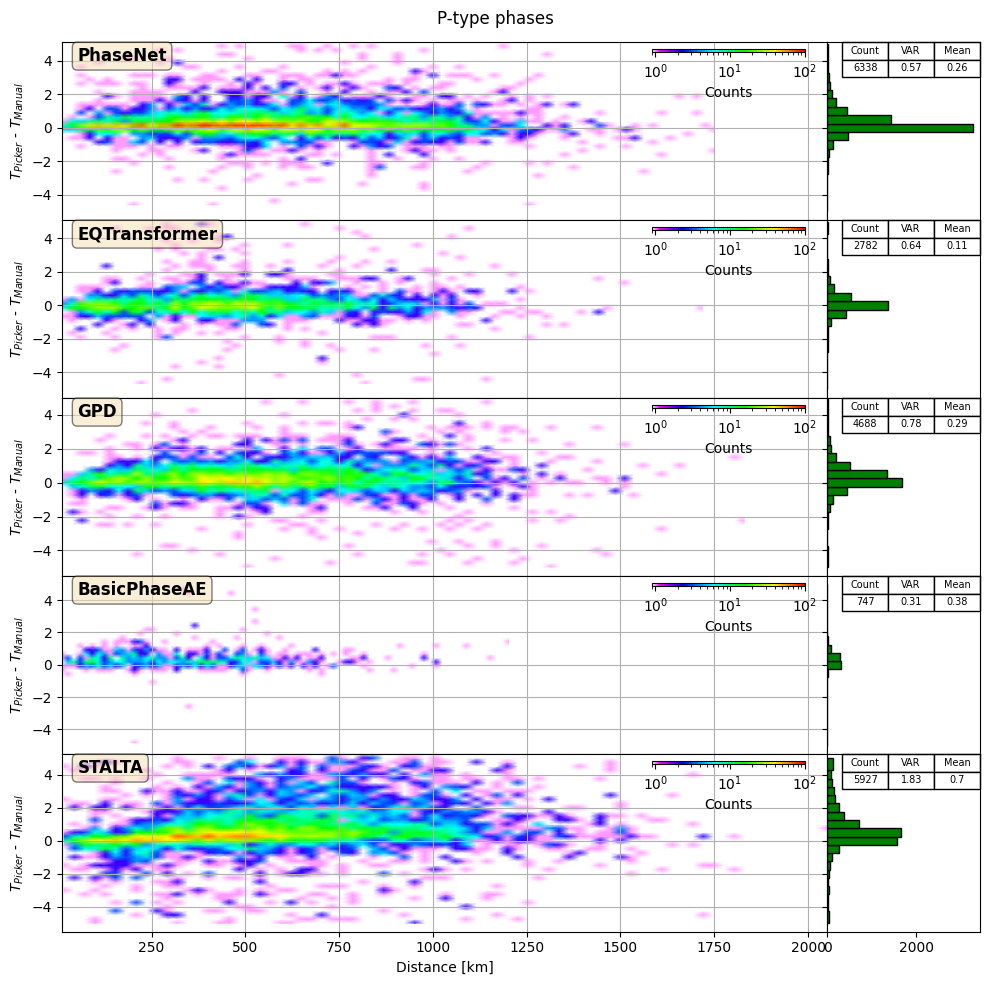

vmax=8.0
./Analised/M-BasicPhaseAE_PHA-S_TYPE-1_PLOT.png


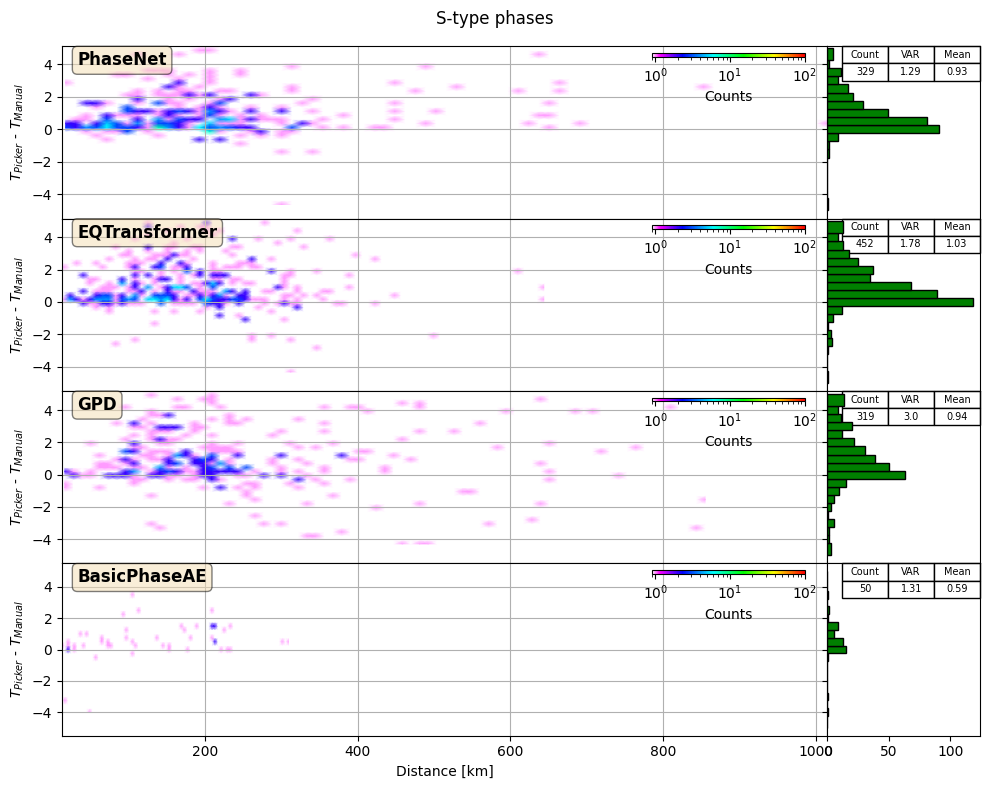

In [110]:
lst_phasetype = df_ta['phasetype'].unique()
for phasetype in ['P', 'S']:#lst_phasetype:
    # print(f'{phasetype=}')
    df_phasetype = df_ta[df_ta['phasetype']==phasetype]
    lst_picker_name = df_phasetype['picker_name'].unique()
    fig, axs = plt.subplots(len(lst_picker_name), 2,
                            sharey='row', sharex='col',
                            gridspec_kw={'width_ratios': [5, 1]})
    fig.suptitle(f'{phasetype}-type phases')
    ###
    density = {}
    for indx, pickertype in enumerate(lst_picker_name):
        df_pickertype = df_phasetype[df_phasetype['picker_name']==pickertype]
        x = df_pickertype['dist_cat'].values
        y = df_pickertype['time_diff'].values
        w = df_pickertype['weight'].values.astype(float)
        xcenters, ycenters, z = mf.plot.ResidualDensity(
            x=x, y=y, ystep=0.25, zreplace=0.9)
        density[pickertype] = (xcenters, ycenters, z)
    vmax = np.max([v[-1].max() for k, v in density.items()])
    print(f'{vmax=}')
    ###
    for indx, pickertype in enumerate(lst_picker_name):
        ax_left, ax_right = axs[indx, :]
        ###
        xcenters, ycenters, z = density[pickertype]
        im = mf.plot.ResidualDistanceDensity(
            xcenters, ycenters, z,
            vmin=0.9, vmax=100,
            fig=fig,
            ax=ax_left,
            save=False, show=False,
            size=(10, len(lst_picker_name)*2),
            show_cmap=True
            )
        mf.plot.PickerLabel(label=pickertype, ax=ax_left)
        df_pickertype = df_phasetype[df_phasetype['picker_name']==pickertype]
        y = df_pickertype['time_diff'].values
        mf.plot.ResidualHistogramVertical(
            arr=y,
            ax=ax_right, ylim=[-5, 5]
            )
        mf.plot.Table(
            arr=y, ax=ax_right
            )
    ### color scale
    # bound = [0.8, 1.1, 1, 1]
    # cbaxes = inset_axes(axs[0, 0], width="25%", height="3%", loc=1,
    #                     bbox_to_anchor=(0.5,0,1,1)) 
    # cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')
    # cbaxes.xaxis.set_ticks_position("bottom")
    # cbar.ax.set_xlabel('Counts')
    ####
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    category = 1
    print(f'{plot_dir}/M-{pickertype}_PHA-{phasetype}_TYPE-{category}_PLOT.png')
    # fig.savefig(f'{plot_dir}/PHA-{phasetype}_TYPE-{category}_PLOT.png')
    plt.show()
    plt.close('all')
    # plt.show()

# Undetected

# new Detected